Battle of Neighbourhoods

Introduction :
    Addis Ababa is the capital city of Ethiopia and the African Union and is often called the "African Capital" due to its historical, diplomatic, and political significance for the continent. Located in the foothills of the Entoto Mountains and standing 7,726 feet (2,355 meters) above sea level, it is the third highest capital in the world. It is located in the geographic center of the country.
The fossilized skeleton, and a plaster replica, of the early hominid Lucy (known in Ethiopia as Dinkinesh) is preserved at the Ethiopian National Museum in Addis Ababa. The city is home to the Ethiopian National Library, the Ethiopian Ethnological Museum (and former palace), the Addis Ababa Museum, the Ethiopian Natural History Museum, the Ethiopian Railway Museum and the National Postal Museum.

Business Problem 

Opening of Hotel/Restaurant Shop

I would like to open a hotel/restaurant at the center of Addis Ababa.As it is a tourist and diplomatic  spot,there is already lots of attention towards it.I know there will be many competitors in terms of hotel and restauramt.But keeping them in mind,i need to locate my hotel in place where more people are attracted and comfortable for a stay and a good meal.I want to bring foreign and local peoples attention towards my new hotel.I would like to flavour my retaurant recipe with Italian,American,typical Cultural  foods to grab their taste.

The challenge is to find a suitable location for opening a new hotel / restaurant attracted to all local and foreign people in the centre of all famous venues.


Expected / Interested Audience

60% local and 40% foreign peoples visit hotel / restaurant once in a year.Some people stay for couple of days or more.Also they find some place for hangout or a good meal.Their main focus might be belonging to stay somewhere near to reach venues.

Data section
 What data is used?

We will be completely working on Foursquare data to explore and try to locate our new hotel where more venues like church, temples, beach, museums, memorials that are present nearby.

How will we be solving using this data?

We will looking for midpoint area of venues to locate our new hotel.Before that our major focus will be on all venues present in and around the core place.





In [85]:
# Import libraries
!pip install folium
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("*********   Loaded library     ***********")

*********   Loaded library     ***********


In [208]:
CLIENT_ID = '0XMLJFKUZOACXW5DEYUZELOWOMIHRP32WTTORD4QJRLMMAUD' # your Foursquare ID
CLIENT_SECRET = 'MNALPJDMRC4GXJUABYKIO20GG2LED3DNTXXVQLBJJKFLVWNO' # your Foursquare Secret
VERSION = '20191028'
LIMIT = 150


address ="Addis Ababa"
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

#add='Addis Ababa : {},{}'.format(latitude,longitude)
add='Addis Ababa : {},{}'.format(latitude,longitude)
print(add)

Addis Ababa : 9.0107934,38.7612525


Hotel & restaurant within 1 KM 

In [209]:
#Quering for hotel & restaurant

search_query = 'hotel'
search_query_res = 'restaurant'

radius = 1000
url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)
#url

Send the GET Request of hotel & restaurants and examine the results

In [210]:
results_hotel = requests.get(url_hotel).json()
results_restaurant = requests.get(url_restaurant).json()
#results_hotel

Get relevant part of JSON and transform it into a pandas dataframe

In [211]:
# assign relevant part of JSON to venues
venues_hotel = results_hotel['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_hotel,dataframe_restaurant])

print("There are {} restaurants and hotels at Addis Ababa".format(dataframe.shape[0]))

There are 54 restaurants and hotels at Addis Ababa


Define information of interest and filter dataframe

In [212]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
hotels_df.head()

,name,categories,distance,lat,lng,id
0,"Radisson Blu Hotel, Addis Ababa",Hotel,944,9.016269,38.767810,4f0f24c2e4b07eb237c40354
1,Intercontinental Hotel,Hotel,1059,9.015365,38.769709,4c17e0b46a21c9b66030c897
2,Ethiopian Athletic Fed/National Hotel,Hotel,266,9.012849,38.762489,536104b5498e03d0a3fdd3b6
3,Ghion Hotel,Hotel,343,9.013647,38.760057,4de0f060c65bcc724f4b522f
4,Marriott Hotel Bar,Hotel Bar,446,9.010415,38.765291,579e1f6ecd102f2ed6fff514


Hotels Location 

In [213]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around Addis ababa

# add a red circle marker to represent the core location of Addis ababa
#folium.features.CircleMarker(
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Addis Ababa',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

# add  restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

Methodology section

In this sections we will perform some data analysis and EDA to find insight from data.We will try to understand the current stats of all given data.Probably,clustering or centroid of all venues will help us to locate new hotel.


In [214]:
hotels_df=dataframe_filtered
print("So Now there are {} hotels & restaurants present in Addis Ababa".format(dataframe_filtered.shape[0]))

So Now there are 54 hotels & restaurants present in Addis Ababa


How Far are hotels from the core location

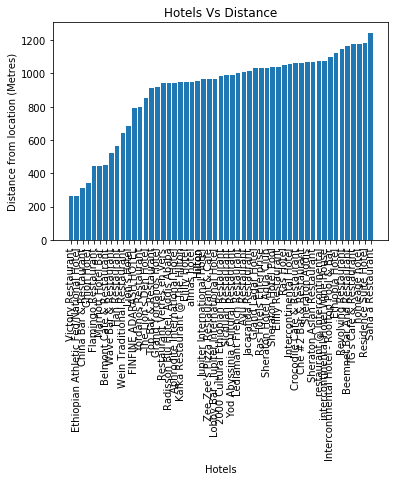

Average distance between hotels and core location is 902 metres


In [215]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.bar(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between hotels and core location is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))



    Sana Restaurant  is far than rest of hotels and restaurant.

    Vectory restaurant remains close to the core spot.

    902 metres is average distance from all hotels to core location.


Explore for other venues around Kanyakumari

A tourist person always wants to visit nearby iconic places.So he wants to reside somewhere nearby to all major venues.We will be exploring more venues around the core location.We will be digging more on main areas or place around 1 km.


In [216]:
radius=1000
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [217]:
import requests

results_venues = requests.get(url_venues).json()
'There are {} venues around Addis Ababa .'.format(len(results_venues['response']['groups'][0]['items']))

'There are 28 venues around Addis Ababa .'

In [218]:
items_venues = results_venues['response']['groups'][0]['items']
#items_venues[0]

In [219]:
dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

0                 Marriott Executive Apartments
1                                 Juventus Club
2                                   Ghion Hotel
3                             Red Terror Museum
4                            Rainforest Day Spa
5                                Han Restaurant
6                                    Greek Club
7               Radisson Blu Hotel, Addis Ababa
8                                  Elilly Hotel
9                                 Tomoca Coffee
10                                Meskel Square
11                  Jupiter International Hotel
12                                       Hilton
13                          Limetree Kazanchies
14                    Restaurant Verres en Vers
15                    Hyatt Regency Addis Ababa
16                                  The Kitchen
17    Marriott Executive Apartments Addis Ababa
18            Yod Abyssinia Cultural Restaurant
19                  National Museum Of Ethiopia
20                 Addis Abeba National 

Extract Venues using Search Queries

When I searched in google map,I could see there were some venues missing.Temples,Church,Parks and Museums are also more recognized by visitors and local audience.So lets bring their data inside.I am not sure why Foursquare hasnt captured it while trying venue query.

Below is the function to extract many queries at a time by passing them in a single list.


In [220]:
# search query function
search_query_list = ['temple','church','park','museum'] 
search_query_list = ['church','park','museum'] 
radius =1000
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng','id']])
search_df

,name,categories,distance,lat,lng,id
0,St. Stephen Church,Church,265,9.011782,38.763447,55eec2b1498ee0668c1f6042
1,Holy Trinity Church (Silase),Church,914,9.005556,38.767664,51544695e4b0b80802754045
2,Holy Savior Catholic Church,Church,945,9.018456,38.764955,4dc6580018387d1bd5559f4f
3,Holy Saviour Church,Church,992,9.013282,38.752584,4e7ed0946da19c8130518eb5
0,Lion Park,Exhibit,939,9.016261,38.767756,51fd0f53498efe72561190e9
1,Addis Ababa Park,Park,997,9.016377,38.768349,52dc81a7498ea6a1c50311ab
2,ambasader park,Restaurant,1101,9.018734,38.755280,50f57c21e4b06e436704b3c0
0,Addis Ababa National Museum,History Museum,226,9.009687,38.762977,4e60e26f483bd9a973a1114b
1,Red Terror Museum,History Museum,323,9.008334,38.762813,5243917611d2fb9191092a1b
2,Red terror martyrs memorial museum,Memorial Site,647,9.010785,38.767140,57af096e498efb6162f5d5c1


In [221]:


# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)




Let us remove hotel & restaurants and get final list of venues.

We could see that there are some hotels/restaurants in the venues list.So we will remove them from the list.We have them in separate dataframe (hotels_df).


In [222]:
to_drop = ['Hotel', 'Restautant','hotel','Resort']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in Addis Ababa".format(df_venues.shape[0]))
df_venues[['name','distance','id']]

There are 35 venues in Addis Ababa


,name,distance,id
0,Marriott Executive Apartments,433,55f00d9a498ef8334c42a905
1,Juventus Club,185,4cc9c15dbcb1b1f74137118a
2,Red Terror Museum,323,5243917611d2fb9191092a1b
3,Rainforest Day Spa,946,50c63a69e4b0fe852f7dd138
4,Han Restaurant,564,5349523e498e57c5c9c2b63a
5,Greek Club,826,4ccaec9254f0b1f74cef0bca
6,Tomoca Coffee,947,4f433cbee4b05d3b15c7c772
7,Meskel Square,52,4f090907e4b00a2752a84f80
8,Hilton,953,4bc8b39cc1c6eee117d9fd92
9,Limetree Kazanchies,988,4d6f647756dea093defcbe8c


Location of all venues

In [223]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Addis Ababa
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Addis Ababa',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        #popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

How far are venues from the core location?

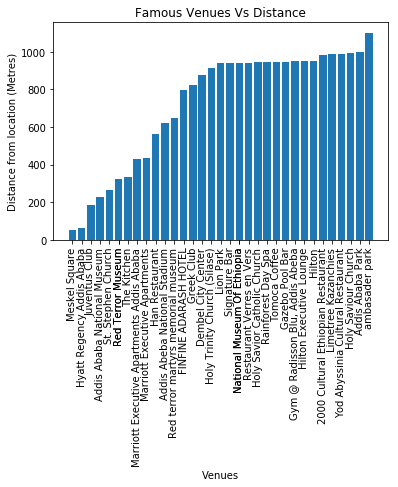

In [224]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()


    We could see Meskel Square,Hayat Regency Addis Ababa and Juventus Club are more closer to our location.
    Ambasader Park is far than rest of places.


Venue Categories

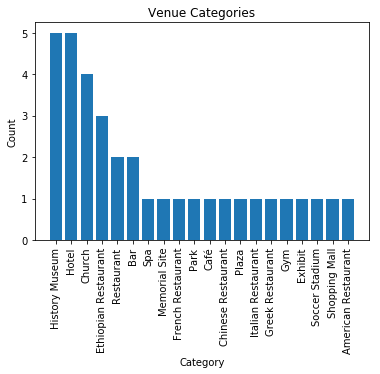

In [225]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()

Eventhough we didnt have immense data to consider distribution of categories we could see that Hotel, History Museum, Church and Restaurant are more common venues.


In [226]:
#Rating of venues
rating_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

Rating of all Venues

In [227]:
rate_dict = {'Venue': df_venues.name, 'Rating': rating_df,'distance':df_venues.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
0,Marriott Executive Apartments,No Rating Yet,433
1,Juventus Club,No Rating Yet,185
2,Red Terror Museum,No Rating Yet,323
3,Rainforest Day Spa,No Rating Yet,946
4,Han Restaurant,No Rating Yet,564
5,Greek Club,No Rating Yet,826
6,Tomoca Coffee,No Rating Yet,947
7,Meskel Square,No Rating Yet,52
8,Hilton,No Rating Yet,953
9,Limetree Kazanchies,No Rating Yet,988


In [228]:
tips_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
try:
    tips=result['response']['venue']['tips']['count']
    tips_df.append(tips)  
except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        tips_df.append(rating)  
  

In [237]:
tips_dict = {'Venue': df_venues.name,'distance':df_venues.distance }
#'Tips': tips_df  'Venue': df_venues.name,'distance':df_venues.distance,

tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('distance',ascending = False)
tips


,Venue,distance
30,ambasader park,1101
29,Addis Ababa Park,997
27,Holy Saviour Church,992
14,Yod Abyssinia Cultural Restaurant,991
9,Limetree Kazanchies,988
23,2000 Cultural Ethiopian Restaurant,983
8,Hilton,953
22,"Gym @ Radisson Blu, Addis Abeba",952
21,Hilton Executive Lounge,952
20,Gazebo Pool Bar,948


In [238]:
# Add Tips column to Rating Dataframe
rate_df['distance']=tips['distance']

#Lets take values of only rated venues
#only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

#only_rated_tips.reset_index(inplace = True,drop = True) 
#only_rated_tips
rate_df

,Venue,Rating,distance
0,Marriott Executive Apartments,No Rating Yet,433
1,Juventus Club,No Rating Yet,185
2,Red Terror Museum,No Rating Yet,323
3,Rainforest Day Spa,No Rating Yet,946
4,Han Restaurant,No Rating Yet,564
5,Greek Club,No Rating Yet,826
6,Tomoca Coffee,No Rating Yet,947
7,Meskel Square,No Rating Yet,52
8,Hilton,No Rating Yet,953
9,Limetree Kazanchies,No Rating Yet,988


Final list of Venues

In [240]:
rated_list=[]
for i in range(len(rate_df)):
    rated_tip_temp=rate_df['Venue'][i]
    rated_list.append(rated_tip_temp)
    
   # rate_df  only_rated_tips

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues

,index,categories,distance,id,lat,lng,name
0,0,Hotel,433,55f00d9a498ef8334c42a905,9.010518,38.765190,Marriott Executive Apartments
1,1,Italian Restaurant,185,4cc9c15dbcb1b1f74137118a,9.009125,38.761264,Juventus Club
2,3,History Museum,323,5243917611d2fb9191092a1b,9.008334,38.762813,Red Terror Museum
3,4,Spa,946,50c63a69e4b0fe852f7dd138,9.016334,38.767788,Rainforest Day Spa
4,5,Chinese Restaurant,564,5349523e498e57c5c9c2b63a,9.008680,38.765919,Han Restaurant
5,6,Greek Restaurant,826,4ccaec9254f0b1f74cef0bca,9.008736,38.768474,Greek Club
6,9,Café,947,4f433cbee4b05d3b15c7c772,9.016336,38.767798,Tomoca Coffee
7,10,Plaza,52,4f090907e4b00a2752a84f80,9.011162,38.761546,Meskel Square
8,12,Hotel,953,4bc8b39cc1c6eee117d9fd92,9.018555,38.764929,Hilton
9,13,American Restaurant,988,4d6f647756dea093defcbe8c,9.014057,38.769617,Limetree Kazanchies


Clustering based on venues

Now lets do some prediction to locate our new hotel in centre of final list of venues.


In [241]:
# one hot encoding
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,American Restaurant,Bar,Café,Chinese Restaurant,Church,Ethiopian Restaurant,Exhibit,French Restaurant,Greek Restaurant,Gym,History Museum,Hotel,Italian Restaurant,Memorial Site,Park,Plaza,Restaurant,Shopping Mall,Soccer Stadium,Spa
0,Marriott Executive Apartments,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Juventus Club,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Red Terror Museum,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Rainforest Day Spa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Han Restaurant,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [242]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [243]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [244]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = final_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Center of all clusters & Midpoint of all venues

We will be collating the location of centroid of all clusters and midpoint of all venues to get more accurate location


In [245]:
fin=neighbor_merged.groupby(['Clustersss']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new hotel:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new hotel:9.01332197349224,38.76424166529277


In [246]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

The location gives the central point to visit all other venues.Hence this can be locked down to attract all tourist.

Results section
 My hotel location

    Final location is pointed at 9.01332197349224,38.76424166529277

    This location is at United nation conventional center.

    Located at exact junction of two cross roads which can give more attention to people who passby.



Spot my hotel against others

    Green - My hotel location
    Red - Addis Ababa core location.
    Black - Venues.
    Blue - Other hotels.
    My predicted location and core location are very close to each other which is expected.As this has central attraction,the predicted one almost matched with the core.


In [ ]:
my_hotel_vs_all = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Addis Ababa


# add a red circle marker to represent the my hotel location
folium.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)


# add a red circle marker to represent the core location of Addis Ababa
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Addis Ababa',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_hotel_vs_all)
    
    
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'],neighbor_merged['New']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(my_hotel_vs_all)


# display map
my_hotel_vs_all

Few more Stats

    Most common categories of venues are Church,Parks and Banks in Addis ababa
    Average distance between all hotels is 454 metres.
    


Discussion section

From above reports,we could get an idea why the predicted one is pointed/clustered on the given spot.First most thing could be the center of attraction for the place.

KMeans have figured out the most common place for all the venues.This output was very adjacent to the core location.This proves the accurate spotting of our predicted algorithm.

Despite of the findings,there were some lack in data.Tips and ratings were missing for most of the venues.Also when I compared foursquare data with google map ,i could see there were many hotels and venues found missing in foursquare.


 Conclusion section

As a business person,one would be able to set up a hotel/restaurant on given spot.This will bring revenue automatically as we have located in very near to core one.We proved this with Kmeans.

Future Expectation:

As mentioned earlier,most of data needs to be extracted from googlemaps.Even though we got somewhat accurate prediction.To be very confident on concluding our output,we may need more data to analyse.

Research based on hotel reviews and restaurant menus could be used for future purpose.

My Experience:

It was wonderful journey for me in IBM capstone and other courses.It can aid to layman people as well who dont know a pinch of Data science.Thanks to Coursera for keeping Skilful instructors with their awesome materials


Thank You 